# Rebuilding MIDIGen

The hand-built model was successful, both as a learning tool and in terms of generating music.

There were however limitations, such as the tokenisation algorithm precluding the use of byte pair encoding, not to mention the lack of of tempo, velocity, instrument, chord, pitch bend data etc.

Additionally, due to the rapid, explorative development with little to no tests there are likely bugs lurking.

Finally, the algorithms were written for clarity rather than raw speed and efficiency.

For all of these reasons, it is worth reconstructing the same model using 'off the shelf' components that have been well tested and optimised, such as [MIDITok](https://miditok.readthedocs.io/en/latest/tokenizing_music_with_miditok.html#) for tokenisation and [LucidRain](https://github.com/lucidrains/x-transformers)'s Transformer implementations which include XLMemory and KNN lookup.

## MIDITok

In the words of the website:

>MidiTok uses a common workflow for all its tokenizers, which follows:
>
>1. **Music file preprocessing**: time is downsampled to match the tokenizer’s time resolution, tracks of the same programs are merged, notes with pitches outside >the tokenizer’s pitch range are removed, note velocities and tempos are downsampled, finally notes, tempos and time signatures are deduplicated;
>
>2. **Parsing of global events**: tempos and time signature tokens are created;
>
>3. **Parsing of the tracks events**: notes, chords, controls (pedals…) and tokens specific to each tracks are parsed to create their associated tokens;
>
>4. **Creating time tokens**: the tokens representing the time are created in order to bind the previously created global and track tokens.
>
>The resulting tokens are provided by the tokenizer as one or miditok.TokSequence depending on the tokenizer’s IO format (Tokens & TokSequence input / output format)
>
>`tokenizer.vocab` holds all the basic tokens describing the note and time attributes of music. After Training a tokenizer, a new vocabulary is built with newly created tokens from pairs of basic tokens. This vocabulary can be accessed with `tokenizer.vocab_model`.

The library supports multiple tokenizers and training algorithms including BPE. It is also highly configurable.

In [1]:
import os
os.chdir(r'9 - Rebuild')
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


In [3]:
from miditok import REMI, TokenizerConfig  # here we choose to use REMI

from miditok import REMI, TokenizerConfig  # here we choose to use REMI

# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    # "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    # "use_chords": True,
    # "use_rests": False,
    # "use_tempos": True,
    # "use_time_signatures": False,
    # "use_programs": False,
    # "num_tempos": 32,  # number of tempo bins
    # "tempo_range": (40, 250),  # (min, max)
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# https://miditok.readthedocs.io/en/latest/tokenizations.html#remi
tokenizer = REMI(config)

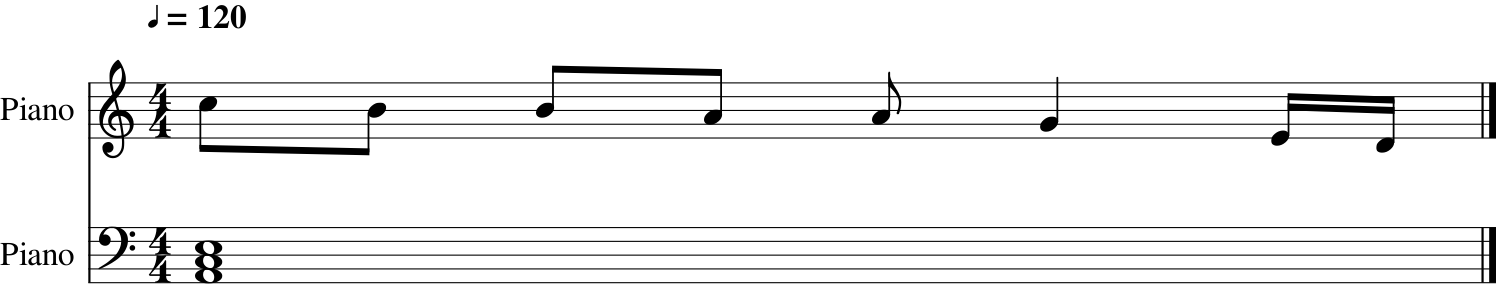

In [4]:
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

single_bar_path = Path('../data/midi/single_bar_example.mid')
single_bar_midi_file = m21.midi.MidiFile()
single_bar_midi_file.open(single_bar_path)
single_bar_midi_file.read()
single_bar_midi_file.close()

single_bar_stream = m21.midi.translate.midiFileToStream(single_bar_midi_file)
single_bar_stream.show()

In [5]:
single_bar_stream.show('midi')

In [6]:
tokens = tokenizer.encode(single_bar_path)  # automatically detects Score objects, paths, tokens
tokens

[TokSequence(tokens=['Bar_None', 'Position_0', 'Pitch_72', 'Velocity_91', 'Duration_0.4.8', 'Position_4', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_8', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_12', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_16', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_20', 'Pitch_67', 'Velocity_91', 'Duration_1.0.8', 'Position_28', 'Pitch_64', 'Velocity_91', 'Duration_0.2.8', 'Position_30', 'Pitch_62', 'Velocity_91', 'Duration_0.2.8'], ids=[4, 189, 56, 115, 128, 193, 55, 115, 128, 197, 55, 115, 128, 201, 53, 115, 128, 205, 53, 115, 128, 209, 51, 115, 132, 217, 48, 115, 126, 219, 46, 115, 126], bytes='', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Pitch, value=72, time=0, desc=4), Event(type=Velocity, value=91, time=0, desc=91), Event(type=Duration, value=0.4.8, time=0, desc=4 ticks), Event(type=Position, value=4, time=4, desc=4), Event(type=Pitch, va

Base vocab tokens for sequence:

In [7]:
tokens[0].__len__()

33

In [8]:
tokens[0].tokens

['Bar_None',
 'Position_0',
 'Pitch_72',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_4',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_8',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_12',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_16',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_20',
 'Pitch_67',
 'Velocity_91',
 'Duration_1.0.8',
 'Position_28',
 'Pitch_64',
 'Velocity_91',
 'Duration_0.2.8',
 'Position_30',
 'Pitch_62',
 'Velocity_91',
 'Duration_0.2.8']

In [9]:
syMusicScore = tokenizer.decode(tokens)

single_bar_path_miditok = Path('../data/midi/single_bar_example_miditok.mid')
syMusicScore.dump_midi(single_bar_path_miditok)

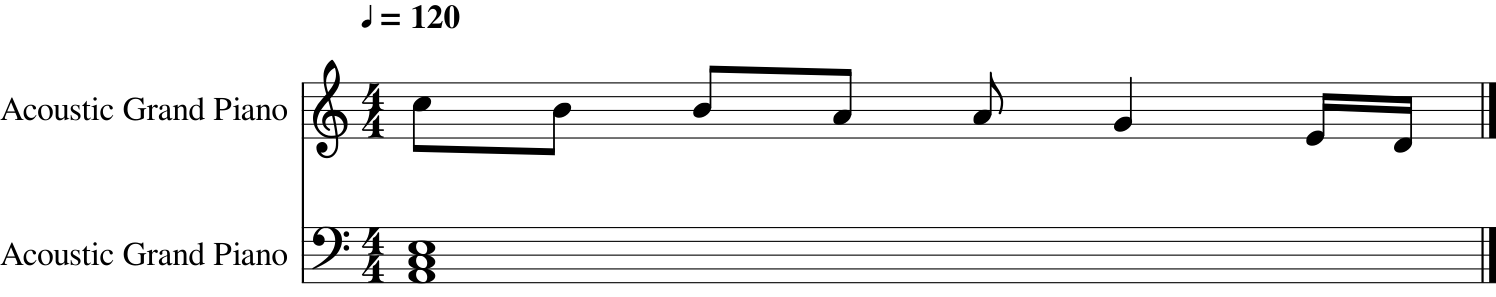

In [10]:
single_bar_miditok_file = m21.midi.MidiFile()
single_bar_miditok_file.open(single_bar_path_miditok)
single_bar_miditok_file.read()
single_bar_miditok_file.close()

single_bar_miditok_stream = m21.midi.translate.midiFileToStream(single_bar_miditok_file)
single_bar_miditok_stream.show()

In [11]:
single_bar_miditok_stream.show('midi')

## Byte Pair encoding

In [12]:
vg_path = Path('../data/midi/vg_large')
vg_tokenizer = REMI()  # using defaults parameters (constants.py)
midi_paths = list(vg_path.glob("**/*.mid"))
vg_tokenizer.train(vocab_size=1000, files_paths=midi_paths)

In [13]:
vg_tokens = vg_tokenizer.encode(single_bar_path)  # automatically detects Score objects, paths, tokens
vg_tokens

[TokSequence(tokens=['Bar_None', 'Position_0', 'Pitch_72', 'Velocity_91', 'Duration_0.4.8', 'Position_4', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_8', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_12', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_16', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_20', 'Pitch_67', 'Velocity_91', 'Duration_1.0.8', 'Position_28', 'Pitch_64', 'Velocity_91', 'Duration_0.2.8', 'Position_30', 'Pitch_62', 'Velocity_91', 'Duration_0.2.8'], ids=[500, 270, 193, 55, 270, 856, 377, 53, 270, 660, 384, 51, 291, 217, 48, 280, 219, 46, 280], bytes='%ÞY\x94¡âX\x94¡æX\x94¡êV\x94¡îV\x94¡òT\x94¥úQ\x94\x9füO\x94\x9f', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Pitch, value=72, time=0, desc=4), Event(type=Velocity, value=91, time=0, desc=91), Event(type=Duration, value=0.4.8, time=0, desc=4 ticks), Event(type=Position, value=4, time=4, desc=4), Event(type=Pitch, valu

Trained vocab tokens for sequence:

In [14]:
vg_tokens[0].__len__()

19

In [15]:
vg_tokens[0].tokens

['Bar_None',
 'Position_0',
 'Pitch_72',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_4',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_8',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_12',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_16',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_20',
 'Pitch_67',
 'Velocity_91',
 'Duration_1.0.8',
 'Position_28',
 'Pitch_64',
 'Velocity_91',
 'Duration_0.2.8',
 'Position_30',
 'Pitch_62',
 'Velocity_91',
 'Duration_0.2.8']

We can collapse all parts into one by passing `use_programs = true` which will include program change tokens in the stream.

In [26]:
# Our parameters
PROGRAM_TOKENIZER_PARAMS = {
    "use_programs": True,
    # "program_changes" : True #This will only add Program tokens when the instrument changes rather than at every note

}
program_config = TokenizerConfig(**PROGRAM_TOKENIZER_PARAMS)

# https://miditok.readthedocs.io/en/latest/tokenizations.html#remi
program_tokenizer = REMI(program_config)
program_tokens = program_tokenizer.encode(single_bar_path)  # automatically detects Score objects, paths, tokens
program_tokens

TokSequence(tokens=['Bar_None', 'Position_0', 'Program_0', 'Pitch_72', 'Velocity_91', 'Duration_0.4.8', 'Program_0', 'Pitch_45', 'Velocity_91', 'Duration_4.0.4', 'Program_0', 'Pitch_48', 'Velocity_91', 'Duration_4.0.4', 'Program_0', 'Pitch_52', 'Velocity_91', 'Duration_4.0.4', 'Position_4', 'Program_0', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_8', 'Program_0', 'Pitch_71', 'Velocity_91', 'Duration_0.4.8', 'Position_12', 'Program_0', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_16', 'Program_0', 'Pitch_69', 'Velocity_91', 'Duration_0.4.8', 'Position_20', 'Program_0', 'Pitch_67', 'Velocity_91', 'Duration_1.0.8', 'Position_28', 'Program_0', 'Pitch_64', 'Velocity_91', 'Duration_0.2.8', 'Position_30', 'Program_0', 'Pitch_62', 'Velocity_91', 'Duration_0.2.8'], ids=[4, 189, 282, 56, 115, 128, 282, 29, 115, 156, 282, 32, 115, 156, 282, 36, 115, 156, 193, 282, 55, 115, 128, 197, 282, 55, 115, 128, 201, 282, 53, 115, 128, 205, 282, 53, 115, 128, 209, 282, 51, 115, 132, 217

In [27]:
program_tokens.__len__()

53

In [28]:
program_tokens.tokens

['Bar_None',
 'Position_0',
 'Program_0',
 'Pitch_72',
 'Velocity_91',
 'Duration_0.4.8',
 'Program_0',
 'Pitch_45',
 'Velocity_91',
 'Duration_4.0.4',
 'Program_0',
 'Pitch_48',
 'Velocity_91',
 'Duration_4.0.4',
 'Program_0',
 'Pitch_52',
 'Velocity_91',
 'Duration_4.0.4',
 'Position_4',
 'Program_0',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_8',
 'Program_0',
 'Pitch_71',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_12',
 'Program_0',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_16',
 'Program_0',
 'Pitch_69',
 'Velocity_91',
 'Duration_0.4.8',
 'Position_20',
 'Program_0',
 'Pitch_67',
 'Velocity_91',
 'Duration_1.0.8',
 'Position_28',
 'Program_0',
 'Pitch_64',
 'Velocity_91',
 'Duration_0.2.8',
 'Position_30',
 'Program_0',
 'Pitch_62',
 'Velocity_91',
 'Duration_0.2.8']